# Setup

In [1]:
# Enable auto-reloading of imports when they have been modified
from IPython import get_ipython
ipython = get_ipython(); assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

import os
import json
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import tqdm

# Disable gradient computation - this notebook will only perform forward passes
torch.set_grad_enabled(False)

from pathlib import Path
import sys
import os

# Add the base (root) directory to the path so we can import the util modules
def get_base_folder(project_root = "Count_PIPNet"):
	# Find the project root dynamically
	current_dir = os.getcwd()
	while True:
		if os.path.basename(current_dir) == project_root:  # Adjust to match your project root folder name
			break
		parent = os.path.dirname(current_dir)
		if parent == current_dir:  # Stop if we reach the system root (failsafe)
			raise RuntimeError(f"Project root {project_root} not found. Check your folder structure.")
		current_dir = parent

	return Path(current_dir)

base_path = get_base_folder() # "PIPNet"
print(f"Base path: {base_path}")
sys.path.append(str(base_path))

Base path: /mnt/ssd-1/mechinterp/taras/Count_PIPNet


In [2]:
from util.vis_pipnet import vizualize_network
from pipnet.count_pipnet import get_count_network
from util.checkpoint_manager import CheckpointManager
from pipnet.test import evaluate_model_lightweight
from pipnet.pipnet import get_pipnet
from util.data import get_dataloaders
from util.args import get_args
from util.vis_pipnet import vizualize_network

In [3]:
# Device setup
GPU_TO_USE = 3

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = f"cuda:{GPU_TO_USE}" if torch.cuda.is_available() else "cpu"

print(f'>>> Using {device} device <<<')

>>> Using cuda:3 device <<<


# Loading utilities

In [4]:
# Function to load a model from a checkpoint
def load_model(run_dir, checkpoint_name='net_trained_best', base_path=base_path, gpu_id=GPU_TO_USE):
    """
    Load a model from a checkpoint directory for evaluation purposes.

    Args:
        run_dir: Directory containing the run results
        checkpoint_name: Name of checkpoint to load (default: 'net_trained_best')
        base_path: Base path for dataset directories
        gpu_id: GPU ID to use
        
    Returns:
        Tuple of (net, trainloader, testloader, classes, args, is_count_pipnet)
    """
    # Step 1: Load the configuration used for this run
    metadata_dir = os.path.join(run_dir, 'metadata')
    args_path = os.path.join(metadata_dir, 'args.pickle')

    import pickle
    with open(args_path, 'rb') as f:
        args = pickle.load(f)
    print(f"Loaded configuration from {args_path}")

    # Explicitly set GPU ID to ensure device consistency
    if torch.cuda.is_available():
        args.gpu_ids = str(gpu_id)
        device = torch.device(f'cuda:{gpu_id}')
        torch.cuda.set_device(device)
    else:
        device = torch.device('cpu')

    print(f"Using device: {device}")

    # Step 2: Create dataloaders
    args.log_dir = run_dir  # Use the run directory as log_dir
    trainloader, trainloader_pretraining, trainloader_normal, \
    trainloader_normal_augment, projectloader, valid_loader, testloader, classes = get_dataloaders(args, device, base_path,
                                                                                                    test_set_projection_full=True)
    # Step 3: Create a model with the same architecture
    if hasattr(args, 'model') and args.model == 'count_pipnet':
        is_count_pipnet = True
        net, num_prototypes = get_count_network(
            num_classes=len(classes), 
            args=args,
            max_count=getattr(args, 'max_count', 3),
            use_ste=getattr(args, 'use_ste', False))
    else:
        is_count_pipnet = False
        net, num_prototypes = get_pipnet(len(classes), args)

    # Step 4: Move model to device
    net = net.to(device)

    # Step 5: Forward one batch through the backbone to get the latent output size
    with torch.no_grad():
        # Use a small batch to determine output shape
        xs1, _, _ = next(iter(trainloader))
        xs1 = xs1.to(device)

        # Single-forward pass without DataParallel
        features = net._net(xs1)
        proto_features = net._add_on(features)

        wshape = proto_features.shape[-1]
        args.wshape = wshape  # needed for calculating image patch size
        print(f"Output shape: {proto_features.shape}, setting wshape={wshape}")
            
    # Step 6: Now wrap with DataParallel
    device_ids = [gpu_id]
    print(f"Using device_ids: {device_ids}")
    net = nn.DataParallel(net, device_ids=device_ids)

    # Step 7: Direct checkpoint loading
    checkpoint_path = os.path.join(run_dir, 'checkpoints', checkpoint_name)
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found at {checkpoint_path}, trying alternative paths...")
        # Try with full path as fallback
        if os.path.exists(checkpoint_name):
            checkpoint_path = checkpoint_name
        else:
            # Try other common checkpoint names
            alternatives = [
                os.path.join(run_dir, 'checkpoints', 'net_trained_last'),
                os.path.join(run_dir, 'checkpoints', 'net_trained'),
                checkpoint_name # in case the direct path was passed
            ]
            for alt_path in alternatives:
                if os.path.exists(alt_path):
                    checkpoint_path = alt_path
                    print(f"Found alternative checkpoint at {checkpoint_path}")
                    break
            else:
                print("No checkpoint found")
                return None, None, None, None, None, None

    try:
        # Load just the model state dict
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        if 'model_state_dict' in checkpoint:
            net.load_state_dict(checkpoint['model_state_dict'], strict=True)
            print(f"Successfully loaded model state from {checkpoint_path}")
            
            # Display additional information if available
            if 'epoch' in checkpoint:
                print(f"Checkpoint from epoch {checkpoint['epoch']}")
            if 'accuracy' in checkpoint:
                print(f"Model accuracy: {checkpoint['accuracy']:.4f}")
            
            return net, testloader, classes, args, is_count_pipnet
        else:
            print(f"Checkpoint doesn't contain model_state_dict")
            return None, None, None, None, None, None
            
    except Exception as e:
        print(f"Error loading checkpoint: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None, None, None, None

# Evaluation utilities

In [5]:
import warnings
# Suppress SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
def evaluate_model(net, testloader, device, args=None):
    """
    Evaluate a model on the test set using a lightweight evaluation.
    
    Args:
        net: The model to evaluate
        testloader: DataLoader for the test set
        device: Device to run evaluation on
        args: Arguments object containing parameters (optional)
        
    Returns:
        Dictionary containing evaluation metrics
    """
    print("Evaluating model...")
    
    # Use the lightweight evaluation function
    eval_info = evaluate_model_lightweight(net, testloader, device)
    
    # If you still want to run the full eval_pipnet for additional metrics,
    # you can add a parameter to control this
    if args and getattr(args, 'run_full_evaluation', False):
        from pipnet.test import eval_pipnet
        enforce_weight_sparsity = getattr(args, 'enforce_weight_sparsity', True)
        full_eval_info = eval_pipnet(net, testloader, "evaluation", device, 
                                    log=None, enforce_weight_sparsity=enforce_weight_sparsity,
                                    args=args)
        # Add full evaluation metrics to the results
        eval_info.update(full_eval_info)
    
    return eval_info

In [7]:
# Function to load and parse the log_epoch_overview.csv file
def load_training_metrics(run_dir):
    """
    Load the training metrics from the log_epoch_overview.csv file.
    
    Args:
        run_dir: Directory containing the run results
        
    Returns:
        pandas DataFrame containing the metrics
    """
    log_path = os.path.join(run_dir, 'log_epoch_overview.csv')
    
    if not os.path.exists(log_path):
        print(f"Log file not found at {log_path}")
        return None
    
    try:
        # Load the CSV file
        df = pd.read_csv(log_path)
        
        # Convert 'n.a.' strings to NaN
        df = df.replace('n.a.', np.nan)
        
        # Convert to numeric types where possible
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='ignore')
        
        # Determine which epochs were pretraining
        pretraining_mask = df['test_top1_acc'].isna()
        df['phase'] = 'training'
        df.loc[pretraining_mask, 'phase'] = 'pretraining'
        
        # Calculate the real epoch number (pretraining + training)
        df['real_epoch'] = df.index + 1
        
        # Calculate the training epoch number (just for the training phase)
        training_epochs = (~pretraining_mask).cumsum()
        df.loc[~pretraining_mask, 'training_epoch'] = training_epochs[~pretraining_mask]
        
        return df
    
    except Exception as e:
        print(f"Error loading log file: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

## Seed group evaluation

In [8]:
# Function to extract meaningful name and seed from run directory name
def extract_name_and_seed(run_name):
    """
    Extract the meaningful name and seed from a run directory name.
    
    Args:
        run_name: Name of the run directory
    
    Returns:
        Tuple of (meaningful_name, seed, full_name)
    """
    import re
    
    # Try to match patterns like "_s{seed}_" or "seed{seed}_" in the name
    seed_pattern = r'_s(\d+)_|seed(\d+)_'
    seed_match = re.search(seed_pattern, run_name)
    
    if seed_match:
        # Extract the seed value from the first successful group
        seed = seed_match.group(1) if seed_match.group(1) else seed_match.group(2)
        
        # Remove date pattern (assuming format like 'YYYYMMDD_HHMMSS_')
        date_pattern = r'^\d{8}_\d{6}_\d+_'
        name_without_date = re.sub(date_pattern, '', run_name)
        
        # Replace the seed part with a placeholder to get the meaningful name
        meaningful_name = re.sub(seed_pattern, '_SEED_', name_without_date)
        
        return meaningful_name, seed, run_name
    else:
        # If no seed found, use the full name
        return run_name, None, run_name

# Function to group run directories by meaningful name (ignoring seed and date)
def group_runs_by_config(run_dirs):
    """
    Group run directories by configuration (ignoring seed and date).
    
    Args:
        run_dirs: Dictionary mapping run names to run directories
    
    Returns:
        Dictionary mapping meaningful names to lists of (seed, run_dir) tuples
    """
    config_groups = {}
    
    for run_name, run_dir in run_dirs.items():
        meaningful_name, seed, full_name = extract_name_and_seed(run_name)
        
        if seed is not None:  # Only consider runs with identified seeds
            if meaningful_name not in config_groups:
                config_groups[meaningful_name] = []
            
            config_groups[meaningful_name].append((seed, run_dir, full_name))
    
    # Sort runs within each group by seed
    for group_name in config_groups:
        config_groups[group_name].sort(key=lambda x: int(x[0]))
    
    # Print summary of found groups
    print(f"Found {len(config_groups)} configuration groups:")
    for group_name, runs in config_groups.items():
        seed_list = [seed for seed, _, _ in runs]
        print(f"  - {group_name}: {len(runs)} runs with seeds {', '.join(seed_list)}")
    
    return config_groups

In [9]:
from util.histograms import class_idx_to_name
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate a group of runs with the same configuration but different seeds
def evaluate_run_group(config_name, seed_runs, output_dir, plot_confusion_matrix = True,
                       metrics_to_plot=None, plot_individual_seeds=True):
    """
    Evaluate a group of runs with the same configuration but different seeds.
    
    Args:
        config_name: Name of the configuration group
        seed_runs: List of (seed, run_dir, full_name) tuples for runs in this group
        output_dir: Directory to save evaluation results
    
    Returns:
        Dictionary containing evaluation results
    """
    print(f"\n{'='*60}")
    print(f"Evaluating configuration group: {config_name}")
    print(f"{'='*60}")

    # Hard-code the desired order for the confusion matrix
    desired_order = [
        "1 Circle", "2 Circles", "3 Circles",
        "1 Triangle", "2 Triangles", "3 Triangles",
        "1 Hexagon", "2 Hexagons", "3 Hexagons"
    ]
    
    group_output_dir = os.path.join(output_dir, config_name)
    os.makedirs(group_output_dir, exist_ok=True)
    
    results = {
        'config_name': config_name,
        'seeds': [],
        'test_accuracies': [],
        'seed_metrics': {}
    }
    
    # Initialize DataFrames for collecting metrics across seeds
    metrics_dfs = []
    
    # Evaluate each seed
    for seed, run_dir, full_name in seed_runs:
        print(f"\nEvaluating seed {seed} from {os.path.basename(run_dir)}")
        
        seed_output_dir = os.path.join(group_output_dir, f"seed_{seed}")
        os.makedirs(seed_output_dir, exist_ok=True)
        
        # Load the model for this seed
        net, testloader, classes, args, is_count_pipnet = load_model(
            run_dir, checkpoint_name='net_trained_best'
        )
        
        # Evaluate on test set
        eval_info = evaluate_model(net, testloader, device, args)

        # print(f'Finished evaluating {full_name}, results:\n', eval_info) 
        
        # Record results
        results['seeds'].append(seed)
        results['test_accuracies'].append(eval_info['accuracy'])
        results['seed_metrics'][seed] = eval_info
        
        # Save evaluation results for this seed
        eval_results_path = os.path.join(seed_output_dir, 'test_evaluation.json')
        with open(eval_results_path, 'w') as f:
            # Convert any non-serializable objects to strings
            serializable_info = {}
            for k, v in eval_info.items():
                if isinstance(v, (int, float, str, bool, list, dict)) or v is None:
                    serializable_info[k] = v
                else:
                    serializable_info[k] = str(v)
                    
            json.dump(serializable_info, f, indent=2)

        # Load training metrics for this seed
        df = load_training_metrics(run_dir)
        if df is not None:
            # Add seed information to the DataFrame
            df['seed'] = seed
            df['full_name'] = full_name
            metrics_dfs.append(df)

        # Plot confusion matrix if available
        if plot_confusion_matrix and 'confusion_matrix' in eval_info:
            # Create a directory for visualization
            vis_dir = os.path.join(seed_output_dir, 'visualizations')
            os.makedirs(vis_dir, exist_ok=True)
    
            # Get confusion matrix and class information
            cm = eval_info['confusion_matrix']
            num_classes = eval_info['num_classes']
            
            # Get class names for all indices
            class_names = [class_idx_to_name(i) for i in range(num_classes)]
            
            # Convert class names to indices
            reorder_idx = []
            for desired_name in desired_order:
                if desired_name in class_names:
                    idx = class_names.index(desired_name)
                    reorder_idx.append(idx)
            
            # If we have the wrong number of classes, fall back to original order
            if len(reorder_idx) != num_classes:
                print(f"Warning: Not all classes found in desired order. Using original order.")
                reorder_idx = list(range(num_classes))
            
            # Reorder confusion matrix
            cm_reordered = cm[reorder_idx, :][:, reorder_idx]
            class_names_reordered = [class_names[i] for i in reorder_idx]
            
            # Plot confusion matrix
            plt.figure(figsize=(12, 10))
            sns.heatmap(cm_reordered, annot=True, fmt='d', cmap='Blues',
                       xticklabels=class_names_reordered,
                       yticklabels=class_names_reordered)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix {full_name}')
            
            # Rotate x labels for better readability
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            
            # Save the plot
            cm_path = os.path.join(vis_dir, 'confusion_matrix.png')
            plt.savefig(cm_path, bbox_inches='tight')
    
            display(plt.gcf())
            plt.close()
    
    # Calculate mean and standard deviation of test accuracies
    if results['test_accuracies']:
        results['mean_accuracy'] = np.mean(results['test_accuracies'])
        results['std_accuracy'] = np.std(results['test_accuracies'])
        
        print(f"\nTest accuracy across {len(results['seeds'])} seeds:")
        print(f"  Mean: {results['mean_accuracy']:.4f}")
        print(f"  Std: {results['std_accuracy']:.4f}")
        print(f"  Range: {min(results['test_accuracies']):.4f} - {max(results['test_accuracies']):.4f}")
        
        # Save summary of test accuracies
        summary_path = os.path.join(group_output_dir, 'test_accuracy_summary.json')
        with open(summary_path, 'w') as f:
            json.dump({
                'config_name': config_name,
                'seeds': results['seeds'],
                'test_accuracies': results['test_accuracies'],
                'mean_accuracy': results['mean_accuracy'],
                'std_accuracy': results['std_accuracy']
            }, f, indent=2)
    
    # Merge metrics DataFrames and create plots with error bars
    if metrics_dfs:
        combined_df = pd.concat(metrics_dfs, ignore_index=True)
        results['combined_metrics'] = combined_df
        
        # Plot metrics with error bars
        plot_group_metrics(combined_df, group_output_dir, config_name, metrics_to_plot=metrics_to_plot,
                           plot_individual_seeds=plot_individual_seeds)
    
    return results

## Plotting functions

In [10]:
import os
from plotly.io import write_image

def sanitize_filename(title: str) -> str:
    """Sanitize the title string to be a valid filename."""
    return "".join(c if c.isalnum() or c in (' ', '-', '_') else '_' for c in title).replace(' ', '_')

def export_plotly_figure_images(fig, title, output_dir, suffix="", png_scale=1):
    """Export a Plotly figure to high-res PNG and PDF using a sanitized title."""
    # Sanitize filename
    base_name = sanitize_filename(title)
    if suffix:
        base_name += f"_{suffix}"

    # Define full paths
    png_path = os.path.join(output_dir, f"{base_name}.png")
    pdf_path = os.path.join(output_dir, f"{base_name}.pdf")

    # Get layout width and height (fallbacks if not set)
    width = fig.layout.width or 1000
    height = fig.layout.height or 600

    # Export high-res PNG and PDF
    write_image(fig, png_path, width=width, height=height, engine="orca", scale=png_scale)
    write_image(fig, pdf_path, width=width, height=height, engine="orca")

def plot_group_metrics(combined_df, output_dir, config_name, metrics_to_plot=None,
                       plot_individual_seeds=False, num_y_ticks=10, suffix=""):
    """
    Plot metrics for a group of runs with the same configuration but different seeds.
    Now supports plotting multiple metrics on the same graph.
    
    Args:
        combined_df: DataFrame containing metrics for all seeds
        output_dir: Directory to save plots
        config_name: Name of the configuration group
        metrics_to_plot: List of metrics to plot. Can contain:
                         - Tuples (metric, title, y_axis_title) for single metrics
                         - Lists of tuples [(metric1, title1, y_label1), ...] for multiple metrics on same plot
    
    Returns:
        Dictionary of plotly figure objects
    """
    figures = {}

    if metrics_to_plot is None:
        # Default metrics to plot if none provided
        metrics_to_plot = [
            ('test_top1_acc', 'Test Accuracy', 'Accuracy'),
            ('local_size_for_true_class', 'Local Size for Predicted Class', 'Count'),
            ('local_size_for_all_classes', 'Local Size for All Classes', 'Size'),
            ('num_nonzero_prototypes', 'Global explanation size', 'Size'),
            ('almost_nonzeros_pooled', 'Number of non-zero prototypes', 'Count'),
            ('prototypes_per_class', 'Total explanation size', 'Size')
        ]
    
    # Only keep training phase data
    training_df = combined_df[combined_df['phase'] == 'training']
    
    # Process each item in metrics_to_plot
    for item in metrics_to_plot:
        # Check if the item is a list (multiple metrics to plot together)
        if isinstance(item, list):
            # Plot multiple metrics on the same figure
            plot_multiple_metrics(training_df, item, output_dir, config_name, figures, plot_individual_seeds, 
                                  num_y_ticks=num_y_ticks, suffix=suffix)
        else:
            # Plot a single metric (original behavior)
            metric, title, y_axis_title = item
            if metric in training_df.columns and not training_df[metric].isna().all():
                plot_single_metric(training_df, metric, title, y_axis_title, output_dir, config_name, figures, plot_individual_seeds, 
                                   num_y_ticks=num_y_ticks, suffix=suffix)
    
    return figures

def plot_single_metric(training_df, metric, title, y_axis_title, output_dir, config_name, figures, plot_individual_seeds=False,
                       num_y_ticks = 10, suffix=""):
    """Plot a single metric with error bars (extracted from original function)."""
    # Group by training epoch and calculate statistics
    metrics_by_epoch = training_df.groupby('training_epoch')[metric].agg(['mean', 'std']).reset_index()
    
    # Create figure with error bars
    fig = go.Figure()
    
    # Add mean line
    fig.add_trace(go.Scatter(
        x=metrics_by_epoch['training_epoch'],
        y=metrics_by_epoch['mean'],
        mode='lines',
        name='Mean',
        line=dict(color='royalblue'),
        marker=dict(size=8)
    ))
    
    # Add error bands (mean ± std)
    fig.add_trace(go.Scatter(
        x=metrics_by_epoch['training_epoch'],
        y=metrics_by_epoch['mean'] + metrics_by_epoch['std'],
        mode='lines',
        name='Upper Bound',
        line=dict(width=0),
        showlegend=False
    ))
    
    fig.add_trace(go.Scatter(
        x=metrics_by_epoch['training_epoch'],
        y=metrics_by_epoch['mean'] - metrics_by_epoch['std'],
        mode='lines',
        name='Lower Bound',
        line=dict(width=0),
        fill='tonexty',
        fillcolor='rgba(65, 105, 225, 0.2)',
        showlegend=False
    ))
    
    # Compute the y-axis range
    y_min = metrics_by_epoch['mean'].min()
    y_max = metrics_by_epoch['mean'].max()
    y_range = y_max - y_min
    
    # Dynamically determine y-axis tick step
    dtick = max(1, round(y_range / num_y_ticks))  # ensure at least 1 unit spacing

    # Update layout
    fig.update_layout(
        title=f"{title} (Mean ± Std across seeds) - {config_name}",
        xaxis_title="Epoch",
        yaxis_title=y_axis_title,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True, dtick=dtick if 'Accuracy' not in y_axis_title else 0.1),
        hovermode="x unified",
        height=600
    )

    export_plotly_figure_images(fig, title, output_dir, suffix or "with_error_bars")
    
    # Save figure
    fig_path = os.path.join(output_dir, f"{metric}_with_error_bars.html")
    fig.write_html(fig_path)
    
    # Display the figure in the notebook
    from IPython.display import display
    display(fig)
    
    figures[metric] = fig
    
    if plot_individual_seeds:
        # Create individual seeds plot (keeping original functionality)
        fig = px.line(
            training_df, 
            x='training_epoch', 
            y=metric, 
            color='seed',
            title=f"{title} (Individual Seeds) - {config_name}",
            labels={'training_epoch': 'Epoch', metric: y_axis_title}
        )
        
        fig.update_layout(
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
            xaxis=dict(showgrid=True),
            yaxis=dict(showgrid=True, dtick=dtick if 'Accuracy' not in y_axis_title else 0.1),
        )
        
        fig_path = os.path.join(output_dir, f"{metric}_individual_seeds.html")
        fig.write_html(fig_path)
        export_plotly_figure_images(fig, f"{title} (Individual Seeds)", output_dir, suffix or "individual_seeds")
        display(fig)
        
        figures[f"{metric}_individual"] = fig

def plot_multiple_metrics(training_df, metrics_list, output_dir, config_name, figures, plot_individual_seeds=False,
                          num_y_ticks = 10, suffix=""):
    """Plot multiple metrics on the same figure with error bars."""
    # Extract metrics that exist in the DataFrame
    valid_metrics = []
    for metric_tuple in metrics_list:
        metric, title, _ = metric_tuple
        if metric in training_df.columns and not training_df[metric].isna().all():
            valid_metrics.append(metric_tuple)
    
    if not valid_metrics:
        print("No valid metrics to plot together")
        return
    
    # Create a combined title from all metric titles
    combined_title = " & ".join([title for _, title, _ in valid_metrics])
    
    # Use the y-axis title from the first metric (assuming they have the same unit)
    y_axis_title = valid_metrics[0][2]
    
    # Create figure for multiple metrics
    fig = go.Figure()
    
    # Define colors for lines and fill areas
    line_colors = ['royalblue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray']
    fill_colors = [
        'rgba(65, 105, 225, 0.2)',  # royalblue with alpha
        'rgba(0, 128, 0, 0.2)',     # green with alpha
        'rgba(255, 0, 0, 0.2)',     # red with alpha
        'rgba(128, 0, 128, 0.2)',   # purple with alpha
        'rgba(255, 165, 0, 0.2)',   # orange with alpha
        'rgba(165, 42, 42, 0.2)',   # brown with alpha
        'rgba(255, 192, 203, 0.2)', # pink with alpha
        'rgba(128, 128, 128, 0.2)'  # gray with alpha
    ]
    
    # Add each metric to the figure
    for i, (metric, title, _) in enumerate(valid_metrics):
        color_idx = i % len(line_colors)
        line_color = line_colors[color_idx]
        fill_color = fill_colors[color_idx]
        
        # Group by training epoch and calculate statistics
        metrics_by_epoch = training_df.groupby('training_epoch')[metric].agg(['mean', 'std']).reset_index()
        
        # Add mean line
        fig.add_trace(go.Scatter(
            x=metrics_by_epoch['training_epoch'],
            y=metrics_by_epoch['mean'],
            mode='lines',
            name=f"{title}",
            line=dict(color=line_color),
            marker=dict(size=8)
        ))
        
        # Add error bands (mean ± std)
        fig.add_trace(go.Scatter(
            x=metrics_by_epoch['training_epoch'],
            y=metrics_by_epoch['mean'] + metrics_by_epoch['std'],
            mode='lines',
            name=f"{title} (Upper)",
            line=dict(width=0),
            showlegend=False
        ))
        
        fig.add_trace(go.Scatter(
            x=metrics_by_epoch['training_epoch'],
            y=metrics_by_epoch['mean'] - metrics_by_epoch['std'],
            mode='lines',
            name=f"{title} (Lower)",
            line=dict(width=0),
            fill='tonexty',
            fillcolor=fill_color,
            showlegend=False
        ))
    
    # Compute the y-axis range
    y_min = metrics_by_epoch['mean'].min()
    y_max = metrics_by_epoch['mean'].max()
    y_range = y_max - y_min
    
    # Dynamically determine y-axis tick step
    dtick = max(1, round(y_range / num_y_ticks))  # ensure at least 1 unit spacing

    # Update layout
    fig.update_layout(
        title=f"{combined_title} (Mean ± Std across seeds) - {config_name}",
        xaxis_title="Epoch",
        yaxis_title=y_axis_title,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True, dtick=dtick if 'Accuracy' not in y_axis_title else 0.1),
        hovermode="x unified",
        height=600
    )
    
    # Create a unique filename based on the metrics
    filename = "_and_".join([metric for metric, _, _ in valid_metrics])
    fig_path = os.path.join(output_dir, f"{filename}_combined_with_error_bars.html")
    export_plotly_figure_images(fig, combined_title, output_dir, suffix or "combined_with_error_bars")
    fig.write_html(fig_path)
    
    # Display the figure in the notebook
    from IPython.display import display
    display(fig)
    
    figures[filename] = fig

    if plot_individual_seeds:
        # Also create individual plots for each metric (for consistency with single metric plots)
        for metric, title, y_axis_title in valid_metrics:
            fig = px.line(
                training_df, 
                x='training_epoch', 
                y=metric, 
                color='seed',
                title=f"{title} (Individual Seeds) - {config_name}",
                labels={'training_epoch': 'Epoch', metric: y_axis_title}
            )
            
            fig.update_layout(
                legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                xaxis=dict(showgrid=True),
                yaxis=dict(showgrid=True, dtick=dtick if 'Accuracy' not in y_axis_title else 0.1),
            )
            
            fig_path = os.path.join(output_dir, f"{metric}_individual_seeds.html")
            export_plotly_figure_images(fig, f"{title} (Individual Seeds)", output_dir, suffix or "individual_seeds")
            fig.write_html(fig_path)
            display(fig)
            
            figures[f"{metric}_individual"] = fig

# Loading the models

In [11]:
# Define the base directory for your experiments
multi_experiment_dir = base_path / 'runs/pipnet' 
print(f"Experiment directory: {multi_experiment_dir}")

Experiment directory: /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/pipnet


In [12]:
# Create a directory for saving evaluation results
eval_results_dir = base_path / 'evaluations'
os.makedirs(eval_results_dir, exist_ok=True)
print(f"Evaluation results will be saved to {eval_results_dir}")

Evaluation results will be saved to /mnt/ssd-1/mechinterp/taras/Count_PIPNet/evaluations


In [13]:
summary_path = os.path.join(multi_experiment_dir, 'summary.json')
use_summary = False

if use_summary:
    try:
    	# Load the summary file to get all run directories
    	with open(summary_path, 'r') as f:
    		summary = json.load(f)
    
    	print(f"Found {len(summary)} trained models")
    except FileNotFoundError:
        summary = None
        print(f"Summary file NOT found at {summary_path}. Please ensure the training was completed and the summary file was generated.")
else:
    summary = None

In [19]:
# Option to use hard-coded run directories (specify just the base names)
hard_coded_run_dirs = [
]

if hard_coded_run_dirs:
    # Convert base names to full paths (assume they're in the 'runs/' folder)
    run_dirs = {}
    for run_name in hard_coded_run_dirs:
        full_path = base_path / 'runs' / run_name
        if os.path.isdir(full_path) and os.path.exists(os.path.join(full_path, 'metadata')):
            run_dirs[run_name] = str(full_path)
        else:
            print(f"Warning: Run directory '{run_name}' not found at {full_path}")
    print(f"Using {len(run_dirs)} manually specified run directories")
elif summary is None:
    run_dirs = {}
    for item in os.listdir(multi_experiment_dir):
        item_path = os.path.join(multi_experiment_dir, item)
        if os.path.isdir(item_path) and os.path.exists(os.path.join(item_path, 'metadata')):
            run_dirs[item] = item_path
    print(f"Found {len(run_dirs)} run directories")
else:
    # Use the runs from the summary file
    run_dirs = {os.path.basename(run['log_dir']): run['log_dir'] for run in summary}

Found 21 run directories


In [20]:
# Select only the runs containing a specific string
filter_str = 'stage7_p192'  # Change this to filter different configurations
run_dirs = {dir: value for dir, value in run_dirs.items() if filter_str in dir}
run_dirs  # Display the filtered directories for verification

{'20250514_170854_7_pipnet_s42_stage7_p192': '/mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/pipnet/20250514_170854_7_pipnet_s42_stage7_p192',
 '20250515_014633_10_pipnet_s21_stage7_p192': '/mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/pipnet/20250515_014633_10_pipnet_s21_stage7_p192',
 '20250514_225343_9_pipnet_s88_stage7_p192': '/mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/pipnet/20250514_225343_9_pipnet_s88_stage7_p192',
 '20250514_200106_8_pipnet_s39_stage7_p192': '/mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/pipnet/20250514_200106_8_pipnet_s39_stage7_p192',
 '20250514_141637_6_pipnet_s14_stage7_p192': '/mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/pipnet/20250514_141637_6_pipnet_s14_stage7_p192'}

In [21]:
# Group runs by configuration (ignoring seed and date)
config_groups = group_runs_by_config(run_dirs)
# config_groups

Found 1 configuration groups:
  - pipnet_SEED_stage7_p192: 5 runs with seeds 14, 21, 39, 42, 88


# Main part (multiple seeds)

## Evaluation part

In [22]:
# List of metrics to plot
metrics_to_plot = [
    ('test_top1_acc', 'Test Accuracy', 'Accuracy'),
    [('local_size_for_true_class', 'Local Size for Predicted Class', 'Count'),
    ('local_size_for_all_classes', 'Local Size for All Classes', 'Size')],
    # ('num_nonzero_prototypes', 'Global explanation size', 'Size'),
    # ('almost_nonzeros_pooled', 'Number of non-zero prototypes', 'Count'),
    # ('prototypes_per_class', 'Total explanation size', 'Size')
]

In [23]:
# Evaluate each configuration group
all_group_results = []
for config_name, seed_runs in tqdm(config_groups.items(), desc="Evaluating configuration groups"):
    # Only evaluate groups with multiple seeds
    if len(seed_runs) >= 1:
        group_result = evaluate_run_group(config_name, seed_runs, eval_results_dir, 
                                          plot_confusion_matrix=False, metrics_to_plot=metrics_to_plot,
                                          plot_individual_seeds=True)
        all_group_results.append(group_result)

# Create a summary table of results
print("\nSummary of results by configuration:")
summary_data = []
for result in all_group_results:
    if 'mean_accuracy' in result:
        summary_data.append({
            'config': result['config_name'],
            'num_seeds': len(result['seeds']),
            'mean_accuracy': result['mean_accuracy'],
            'std_accuracy': result['std_accuracy'],
            'min_accuracy': min(result['test_accuracies']),
            'max_accuracy': max(result['test_accuracies'])
        })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('mean_accuracy', ascending=False)
    
    # Save to CSV
    summary_path = os.path.join(eval_results_dir, 'config_results_summary.csv')
    summary_df.to_csv(summary_path, index=False)
    
    # Print summary
    display(summary_df)
    print(f"\nConfiguration summary saved to {summary_path}")

print("\nAnalysis complete!")

Evaluating configuration groups:   0%|          | 0/1 [00:00<?, ?it/s]


Evaluating configuration group: pipnet_SEED_stage7_p192

Evaluating seed 14 from 20250514_141637_6_pipnet_s14_stage7_p192
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/pipnet/20250514_141637_6_pipnet_s14_stage7_p192/metadata/args.pickle
Using device: cuda:3
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.
Number of prototypes set from 768 to 192 . Extra 1x1 conv layer added. Not recommended.
Output shape: torch.Size([64, 192, 22, 22]), setting wshape=22
Using device_ids: [3]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/pipnet/20250514_141637_6_pipnet_s14_stage7_p192/checkpoints/net_trained_best
Checkpoint from epoch 19
Model accuracy: 1.0000
Evaluating model...



Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.84it/s]

Evaluation completed. Accuracy: 0.9978

Evaluating seed 21 from 20250515_014633_10_pipnet_s21_stage7_p192
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/pipnet/20250515_014633_10_pipnet_s21_stage7_p192/metadata/args.pickle
Using device: cuda:3
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.


Number of prototypes set from 768 to 192 . Extra 1x1 conv layer added. Not recommended.
Output shape: torch.Size([64, 192, 22, 22]), setting wshape=22
Using device_ids: [3]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/pipnet/20250515_014633_10_pipnet_s21_stage7_p192/checkpoints/net_trained_best
Checkpoint from epoch 24
Model accuracy: 1.0000
Evaluating model...



Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.07it/s]

Evaluation completed. Accuracy: 1.0000

Evaluating seed 39 from 20250514_200106_8_pipnet_s39_stage7_p192
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/pipnet/20250514_200106_8_pipnet_s39_stage7_p192/metadata/args.pickle
Using device: cuda:3
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.


Number of prototypes set from 768 to 192 . Extra 1x1 conv layer added. Not recommended.
Output shape: torch.Size([64, 192, 22, 22]), setting wshape=22
Using device_ids: [3]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/pipnet/20250514_200106_8_pipnet_s39_stage7_p192/checkpoints/net_trained_best
Checkpoint from epoch 19
Model accuracy: 1.0000
Evaluating model...



Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.96it/s]

Evaluation completed. Accuracy: 0.9989

Evaluating seed 42 from 20250514_170854_7_pipnet_s42_stage7_p192
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/pipnet/20250514_170854_7_pipnet_s42_stage7_p192/metadata/args.pickle
Using device: cuda:3
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.


Number of prototypes set from 768 to 192 . Extra 1x1 conv layer added. Not recommended.
Output shape: torch.Size([64, 192, 22, 22]), setting wshape=22
Using device_ids: [3]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/pipnet/20250514_170854_7_pipnet_s42_stage7_p192/checkpoints/net_trained_best
Checkpoint from epoch 34
Model accuracy: 1.0000
Evaluating model...



Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.06it/s]

Evaluation completed. Accuracy: 0.9978

Evaluating seed 88 from 20250514_225343_9_pipnet_s88_stage7_p192
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/pipnet/20250514_225343_9_pipnet_s88_stage7_p192/metadata/args.pickle
Using device: cuda:3
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.


Number of prototypes set from 768 to 192 . Extra 1x1 conv layer added. Not recommended.
Output shape: torch.Size([64, 192, 22, 22]), setting wshape=22
Using device_ids: [3]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/pipnet/20250514_225343_9_pipnet_s88_stage7_p192/checkpoints/net_trained_best
Checkpoint from epoch 15
Model accuracy: 1.0000
Evaluating model...



Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.09it/s]


Evaluation completed. Accuracy: 0.9989

Test accuracy across 5 seeds:
  Mean: 0.9987
  Std: 0.0008
  Range: 0.9978 - 1.0000


ValueError: 
The orca executable is required in order to export figures as static images,
but the executable that was found at '/home/taras/miniconda3/envs/taras_ami/bin/orca'
does not seem to be a valid plotly orca executable. Please refer to the end of
this message for details on what went wrong.

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca

After installation is complete, no further configuration should be needed.

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path of your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save()

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python

Here is the error that was returned by the command
    $ /home/taras/miniconda3/envs/taras_ami/bin/orca --help

[Return code: 127]
/home/taras/miniconda3/envs/taras_ami/lib/orca_app/orca: error while loading shared libraries: libnss3.so: cannot open shared object file: No such file or directory

Note: When used on Linux, orca requires an X11 display server, but none was
detected. Please install Xvfb and configure plotly.py to run orca using Xvfb
as follows:

    >>> import plotly.io as pio
    >>> pio.orca.config.use_xvfb = True

You can save this configuration for use in future sessions as follows:

    >>> pio.orca.config.save()

See https://www.x.org/releases/X11R7.6/doc/man/man1/Xvfb.1.xhtml
for more info on Xvfb


## Plotting validation metrics

In [31]:
# List of metrics to plot
metrics_to_plot = [
    ('test_top1_acc', 'Test Accuracy', 'Accuracy'),
    [('local_size_for_true_class', 'Local Size for Predicted Class', 'Count'),
    ('local_size_for_all_classes', 'Local Size for All Classes', 'Size'),
    ],
    [('num_nonzero_prototypes', 'Global explanation size', 'Size'),
    ('prototypes_per_class', 'Total explanation size', 'Size')
    ],
    ('almost_nonzeros_pooled', 'Number of non-zero prototypes', 'Count'),
]


Plotting metrics for configuration: pipnet_SEED_stage7_p0


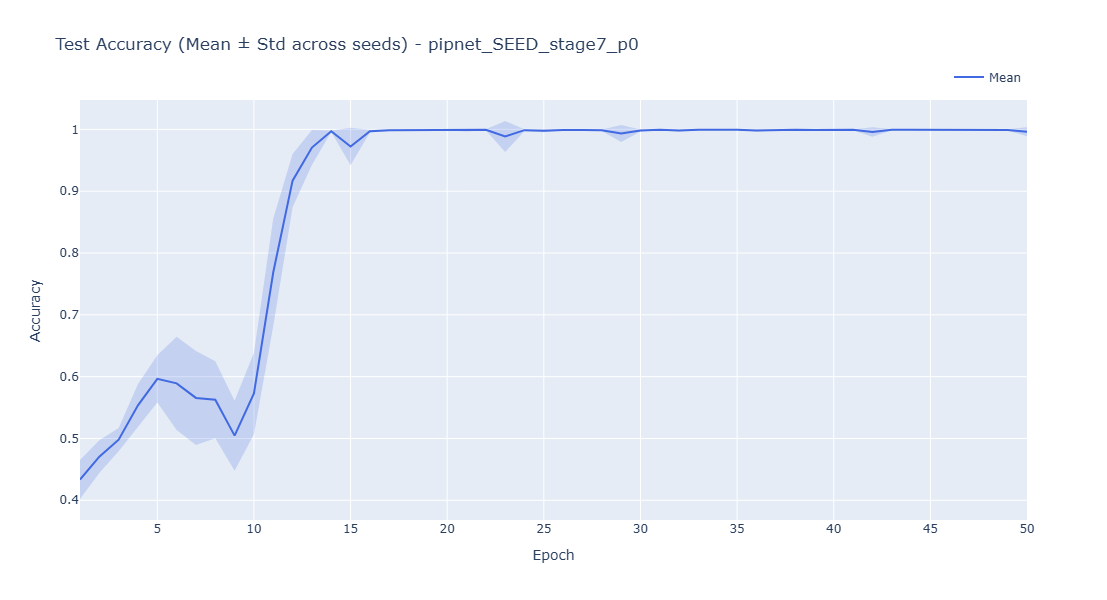

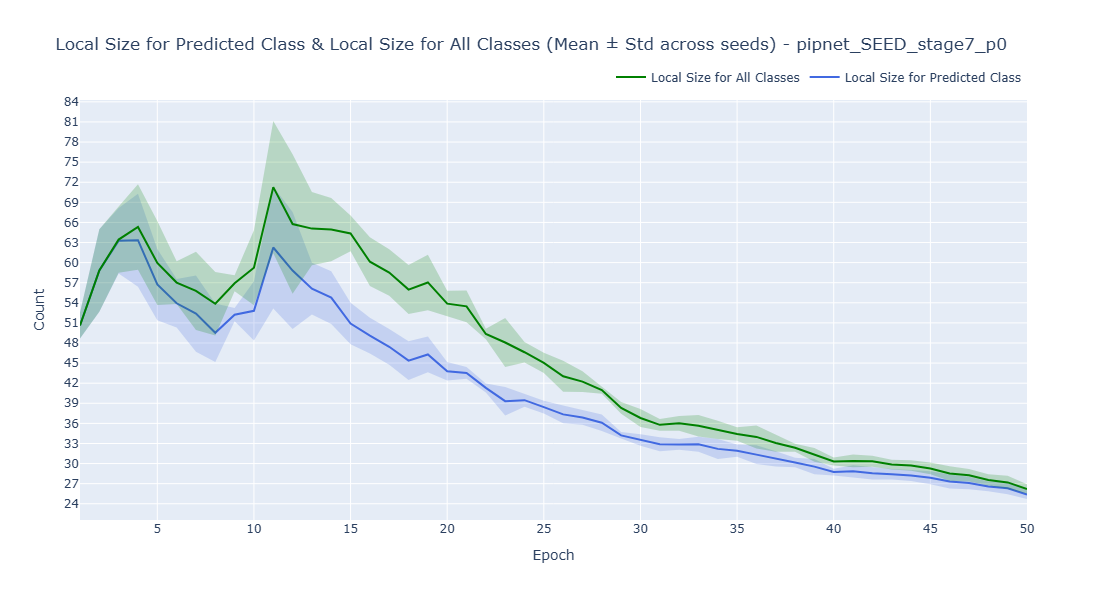

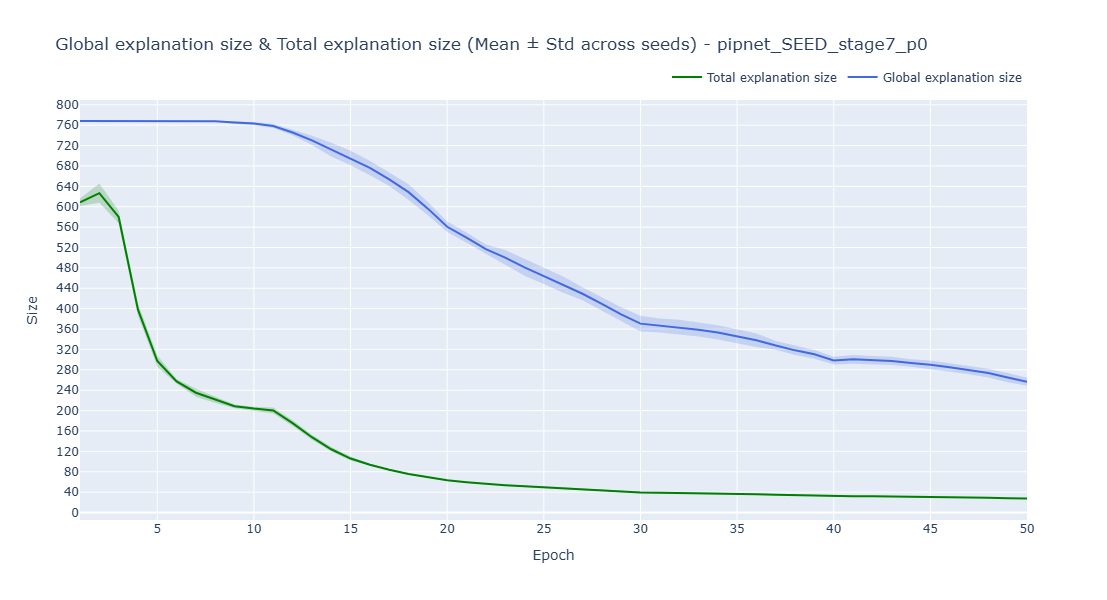

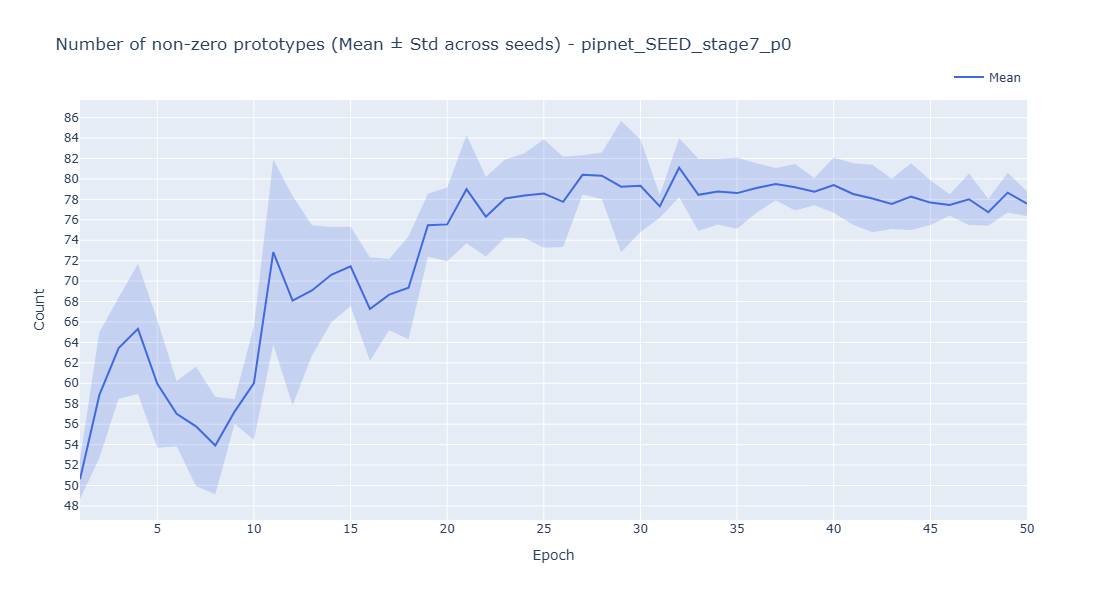

In [34]:
# Visualize metrics for each configuration group
for config_name, seed_runs in config_groups.items():
    print(f"\nPlotting metrics for configuration: {config_name}")
    
    # Create output directory for this configuration
    config_output_dir = os.path.join(eval_results_dir, config_name)
    os.makedirs(config_output_dir, exist_ok=True)
    
    # Collect metrics DataFrames from all seeds in this configuration
    metrics_dfs = []
    for seed, run_dir, full_name in seed_runs:
        df = load_training_metrics(run_dir)
        if df is not None:
            # Add seed information to the DataFrame
            df['seed'] = seed
            df['full_name'] = full_name
            metrics_dfs.append(df)
    
    # Combine metrics from all seeds
    if metrics_dfs:
        combined_df = pd.concat(metrics_dfs, ignore_index=True)
        
        # Plot metrics with error bars
        plot_group_metrics(combined_df, config_output_dir, config_name, metrics_to_plot=metrics_to_plot,
                           num_y_ticks=15, suffix="pipnet_p768")
    else:
        print(f"No metrics data available for configuration: {config_name}")